### Import Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

### Read and format data

In [2]:
PATH_PART_1 = '../data/part 1'

In [3]:
files_list = os.listdir(PATH_PART_1)
files_list

['1623535615-3006-IAJ9206.csv',
 '1624040490-2957-NAI1549.csv',
 '1624374799-3006-MYS2071.csv',
 '1624962426-3006-NAH4736.csv']

In [ ]:
sensors_info_list = []
for i, sensor_file_name in files_list:
    
    start, interval, sensor_name = sensor_file_name.split('.')[0].split('-')
    df = pd.read_csv(f'{PATH_PART_1}/{sensor_file_name}')
    df['Time'] = np.linspace(0, int(interval), df.shape[0]) # Time in ms
    df.set_index('Time', inplace=True)
    sensor_dict={
        'name':sensor_name,
        'start':int(start),
        'interval':int(interval),
        'data':df
    }
    sensors_info_list[sensor_dict]

In [ ]:
sensors_info_list[0]

{'name': 'IAJ9206',
 'start': 1623535615,
 'interval': 3006,
 'data':                     x         y         z
 Time                                     
 0.000000    -1.003174 -0.097778 -0.017334
 0.603736    -0.993591 -0.084778 -0.009766
 1.207471    -0.964844 -0.048462  0.062012
 1.811207    -0.868591 -0.010437  0.103577
 2.414943    -0.885498 -0.041992  0.078003
 ...               ...       ...       ...
 3003.585057 -1.015808  0.047424  0.120422
 3004.188793 -1.054077 -0.048462 -0.051331
 3004.792529 -1.090515 -0.046814 -0.054749
 3005.396264 -1.070557 -0.042114 -0.030212
 3006.000000 -1.016113 -0.079590  0.018066
 
 [4980 rows x 3 columns]}

In [6]:
sensors_info_list[0]['data'] 

x         y         z
Time                                     
0.000000    -1.003174 -0.097778 -0.017334
0.603736    -0.993591 -0.084778 -0.009766
1.207471    -0.964844 -0.048462  0.062012
1.811207    -0.868591 -0.010437  0.103577
2.414943    -0.885498 -0.041992  0.078003
...               ...       ...       ...
3003.585057 -1.015808  0.047424  0.120422
3004.188793 -1.054077 -0.048462 -0.051331
3004.792529 -1.090515 -0.046814 -0.054749
3005.396264 -1.070557 -0.042114 -0.030212
3006.000000 -1.016113 -0.079590  0.018066

[4980 rows x 3 columns]

### Data in time domain

In [7]:
import plotly.graph_objects as go

for sensor_dict in sensors_info_list.values():
    data = sensor_dict['data']
    fig = go.Figure()
    for column in data.columns:
        fig.add_trace(go.Scatter(x=data.index, 
                                 y=data[column], 
                                 mode='lines', 
                                 name=column),)

    fig.update_layout(
        title=sensor_dict['name'],
        xaxis_title='Time [ms]',
        yaxis_title='Acceleration [m/s2]',
        showlegend=True,
    )
    fig.show()

### Data in frequency domain

In [8]:
def apply_fft(series):
    
    N = len(series)
    T = (series.index[1] - series.index[0])/1000
    freq = np.fft.fftfreq(N, T)
    fft = np.abs(np.fft.fft(series))/N
    mask = freq > 0 

    return freq[mask], fft[mask]


In [9]:
from plotly.subplots import make_subplots

for sensor_dict in sensors_info_list.values():
    df = sensor_dict['data']
    num_rows = df.shape[1]

    fig = make_subplots(rows=num_rows, cols=1,  subplot_titles=[f"{col}" for col in df.columns])

    for i, column in enumerate(df.columns):
        freq, fft = apply_fft(df[column])  
        fig.add_trace(go.Scatter(x=freq, y=fft, mode='lines'), row=i+1, col=1)

        # Update layout for each subplot
        fig.update_xaxes(title_text='Frequency [Hz]', row=i+1, col=1)
        fig.update_yaxes(title_text='Spectrum', row=i+1, col=1)

    # Update figure layout
    fig.update_layout(
        title=sensor_dict['name'],
        height=300*num_rows,
        width=1000,
        showlegend=False
    )
    fig.show()

### Filter

In [10]:
from scipy.signal import butter, lfilter, filtfilt, freqz

In [11]:
def butter_lowpass(cutoff, fs, order=4):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [45]:
sensor_idx = 2
axis = 'z'
cutoff_freq = 350 # Cutoff frequency defined by visual inspection

data = sensors_info_list[sensor_idx]['data'][axis]
name = sensors_info_list[sensor_idx]['name']
fs = int(1000/data.index[1]) # Frequency of the signal in Hz

data

Time
0.000000      -0.118225
0.603736      -0.115417
1.207471      -0.067078
1.811207      -0.098022
2.414943      -0.100891
                 ...   
3003.585057    0.065430
3004.188793   -0.014282
3004.792529    0.124329
3005.396264    0.129089
3006.000000    0.022156
Name: z, Length: 4980, dtype: float64

In [41]:
b, a = butter_lowpass(cutoff_freq, fs, order=6)
w, h = freqz(b, a, fs=fs)

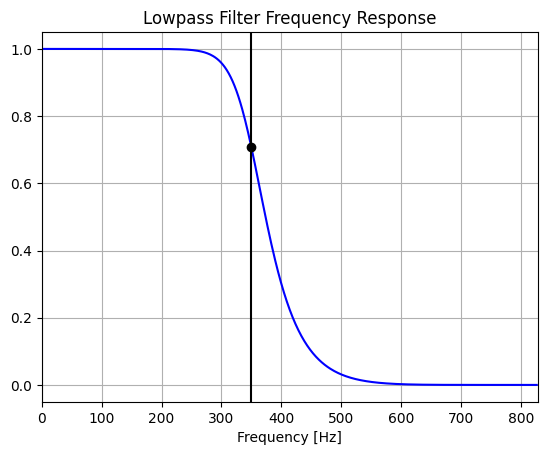

In [42]:
plt.figure()
plt.plot(w, np.abs(h), 'b')
plt.plot(cutoff_freq, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff_freq, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

In [43]:
filtered_data = butter_lowpass_filter(data, cutoff_freq, fs, order=6)
filtered_data = pd.Series(filtered_data, index = data.index)
filtered_data

Time
0.000000      -0.118224
0.603736      -0.088137
1.207471      -0.085404
1.811207      -0.102989
2.414943      -0.106929
                 ...   
3003.585057    0.015236
3004.188793    0.057317
3004.792529    0.106635
3005.396264    0.097091
3006.000000    0.021810
Length: 4980, dtype: float64

In [44]:
fig = go.Figure()    
fig.add_trace(go.Scatter(x=data.index, 
                         y=data.values, 
                         mode='lines',
                         name='Original' 
                         )),
fig.add_trace(go.Scatter(x=filtered_data.index, 
                         y=filtered_data.values, 
                         mode='lines',
                         name='Filtered' 
                         ))
fig.update_xaxes(range=[0, 300])
fig.update_layout(
    title= f'{name} - {axis}',
    xaxis_title='Time [ms]',
    yaxis_title='Acceleration [m/s2]')